<div style="text-align: right">Project - Fanatsy Football Analysis</div>
<div style="text-align: right">Team Members - Akshata Sanjay Jadhav and Aditya Kinare</div>
<div style="text-align: right">Mentor - Pranshu Dixit</div>

# FANTASY FOOTBALL ANALYSIS

<br />
<center>
<img src="images/FPL.PNG" width=1000 />
</center>

### What is Fantasy Premier League?

FPL is a game that casts you in the role of a Fantasy manager of Premier League players. 

You must pick a squad of 15 players from the 2021/22 Premier League, who score points for your team based on their performances for their clubs in PL matches.


### Rules of Premier League :

- Each week, players earn points based on their performance in games throughout the week;

- The aim of the game is to pick players whom you think will  earn the most points in the season;

- You are constrained to a budget of £100.0 million to choose players (better players cost more money);

- You must pick 15 players, 2 goal keepers, 5 defenders, 5 midfielders and 3 strikers;

- Only 11 players must be on the pitch (1 goalkeeper - 4 defenders - 4 midfielders - 2 strikers), and 4 on the bench (1-1-1-1);

- You can only pick up to 3 players from any given team;

- Only the 11 players selected to play can earn points each week.

<br />
<center>
<img src="images/Rules.PNG" width=500 />
</center>

In [3]:
import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from pulp import *
import seaborn as sns
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [4]:
pip install pulp

Note: you may need to restart the kernel to use updated packages.


## Harvesting Data 

Loading the data from the [Fantasy Premier League](https://fantasy.premierleague.com/) site for the year 2021-2022 till gameweek 35

In [5]:
filename = 'fpl.json'
fpl_api = 'https://fantasy.premierleague.com/api/bootstrap-static/'

In [6]:
r = requests.get(fpl_api, allow_redirects=True)
with open(filename, 'wb') as fpl_file:
    fpl_file.write(r.content)

In [7]:
with open(filename) as data_file:    
    fpl_data = json.load(data_file)

In [8]:
player_data_json = fpl_data['elements']
player_data = pd.DataFrame(player_data_json)

*This data frame displays the empty /new players in the dataset*

In [9]:
player_data.iloc[1:10,:]

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,...,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
1,0.0,0.0,115918,0,0,0,0,0,1,0.0,...,485,19,538,54,NaN,,NaN,,NaN,
2,0.0,0.0,47431,0,0,-2,2,0,3,0.0,...,726,303,726,303,NaN,,NaN,,NaN,
3,0.0,0.0,54694,0,0,-4,4,0,4,0.0,...,51,20,155,29,NaN,,NaN,,NaN,
4,100.0,100.0,58822,0,0,-3,3,0,2,2.9,...,319,104,270,90,2.0,,3.0,,NaN,
5,100.0,100.0,59966,0,0,-3,3,1,4,2.1,...,34,13,53,14,NaN,,5.0,,1.0,
6,100.0,100.0,84450,0,0,-2,2,0,3,7.5,...,175,97,132,78,NaN,,4.0,,NaN,
7,0.0,0.0,92371,0,0,-3,3,0,2,0.0,...,409,154,440,158,NaN,,NaN,,NaN,
8,0.0,0.0,98745,0,0,-2,2,0,2,0.0,...,681,244,694,245,NaN,,NaN,,NaN,
9,0.0,0.0,111457,0,0,-3,3,0,2,0.0,...,545,225,505,180,NaN,,NaN,,NaN,


In [10]:
position = {x['id']:x['singular_name_short'] for x in fpl_data['element_types']}
club = {x['id']:x['name'] for x in fpl_data['teams']}

In [11]:
to_drop = ['chance_of_playing_this_round','chance_of_playing_next_round','code','cost_change_event','cost_change_event_fall','cost_change_start','cost_change_start_fall','dreamteam_count','ep_this','event_points','form','ict_index','in_dreamteam','news','photo','special','squad_number','status','transfers_in','transfers_in_event','transfers_out','transfers_out_event','value_form','value_season']
rearrage = ['full_name','first_name','second_name', 'element_type','position','id','club', 'team_code', 'web_name',
                     'saves','penalties_saved','clean_sheets','goals_conceded',
                     'bonus', 'bps','creativity','ep_next','influence', 'threat',
                     'goals_scored','assists','minutes', 'own_goals',
                     'yellow_cards', 'red_cards','penalties_missed',
                     'selected_by_percent', 'now_cost','points_per_game','total_points']
player_data.drop(to_drop, axis=1, inplace = True)


In [12]:
player_data['full_name'] = player_data.first_name + " " + player_data.second_name
player_data['position'] = player_data.element_type.map(position)
player_data['club'] = player_data.team.map(club)
player_data = player_data[rearrage]

In [13]:
player_data.rename(columns = {'element_type':'position_id'}, inplace = True)

In [14]:
player_data

,full_name,first_name,second_name,position_id,position,id,club,team_code,web_name,saves,...,assists,minutes,own_goals,yellow_cards,red_cards,penalties_missed,selected_by_percent,now_cost,points_per_game,total_points
0,Bernd Leno,Bernd,Leno,1,GKP,1,Arsenal,3,Leno,10,...,0,360,0,0,0,0,0.9,45,2.5,10
1,Rúnar Alex Rúnarsson,Rúnar Alex,Rúnarsson,1,GKP,2,Arsenal,3,Rúnarsson,0,...,0,0,0,0,0,0,0.5,40,0.0,0
2,Willian Borges Da Silva,Willian,Borges Da Silva,3,MID,3,Arsenal,3,Willian,0,...,0,0,0,0,0,0,0.1,63,0.0,0
3,Pierre-Emerick Aubameyang,Pierre-Emerick,Aubameyang,4,FWD,4,Arsenal,3,Aubameyang,0,...,1,1036,0,3,0,2,1.2,96,3.1,44
4,Cédric Soares,Cédric,Soares,2,DEF,5,Arsenal,3,Cédric,0,...,0,1160,0,3,0,0,0.5,42,1.8,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,Bruno André Cavaco Jordão,Bruno André,Cavaco Jordão,3,MID,661,Wolves,39,Jordão,0,...,0,0,0,0,0,0,0.0,45,0.0,0
726,Toti António Gomes,Toti António,Gomes,2,DEF,685,Wolves,39,Toti,0,...,0,180,0,1,0,0,0.0,44,1.5,3
727,Dion Sanderson,Dion,Sanderson,2,DEF,686,Wolves,39,Sanderson,0,...,0,0,0,0,0,0,0.0,40,0.0,0
728,Ryan Giles,Ryan,Giles,3,MID,687,Wolves,39,Giles,0,...,0,0,0,0,0,0,0.0,45,0.0,0


## Exploratory Data Analysis

Let's explore the data and find useful insights from it

>To begin with, Let's see the top 10 players who have scored the maximum total points till the present gameweek.

In [15]:
top_ten_players = player_data.nlargest(10, 'total_points')

In [16]:
top_ten_players = top_ten_players[['full_name','total_points']]
top_ten_players

,full_name,total_points
380,Mohamed Salah,256
580,Heung-Min Son,223
384,Trent Alexander-Arnold,202
413,João Pedro Cavaco Cancelo,185
674,Jarrod Bowen,177
376,Virgil van Dijk,175
381,Andrew Robertson,175
19,Bukayo Saka,168
378,Alisson Ramses Becker,166
387,Diogo Jota,166


***Ohhh what A Shockerr!!!!!!! Salah tops the list.. 😉***

>Mean total points on the basis of position

In [17]:
position_mean = player_data.pivot_table(index='position', values='total_points', aggfunc=np.mean)

In [18]:
position_mean

,total_points
position,
DEF,38.870445
FWD,40.336842
GKP,29.987952
MID,40.645902


In [19]:
#plot = position_mean.plot.pie(y='total_points', figsize=(5, 5))

>Teams getting most number of red cards and yellow cards

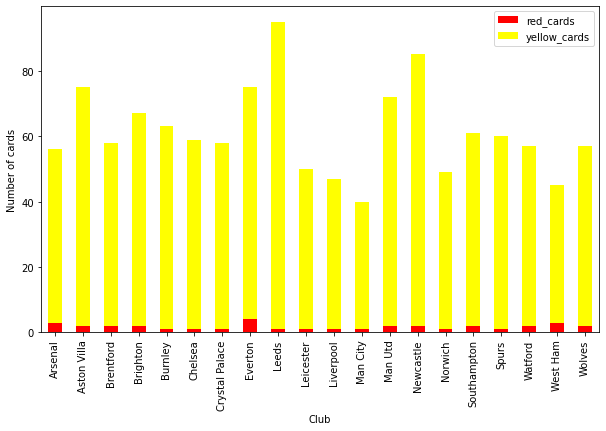

In [20]:
ax = player_data.pivot_table(index='club', values=['red_cards','yellow_cards'], aggfunc=np.sum).plot.bar(stacked=True, color=["red", "yellow"])#.plot(kind='bar')
fig = ax.get_figure()
fig.set_size_inches(10, 6)
ax.set_xlabel("Club")
ax.set_ylabel("Number of cards")
fig.savefig("number_of_cards_barplot.png")


***No wonder Everton and Leeds are getting relegated!!!! 🙈***

Goalkeepers

Text(0.5, 1.0, 'Goalkeeper with maximum total points')

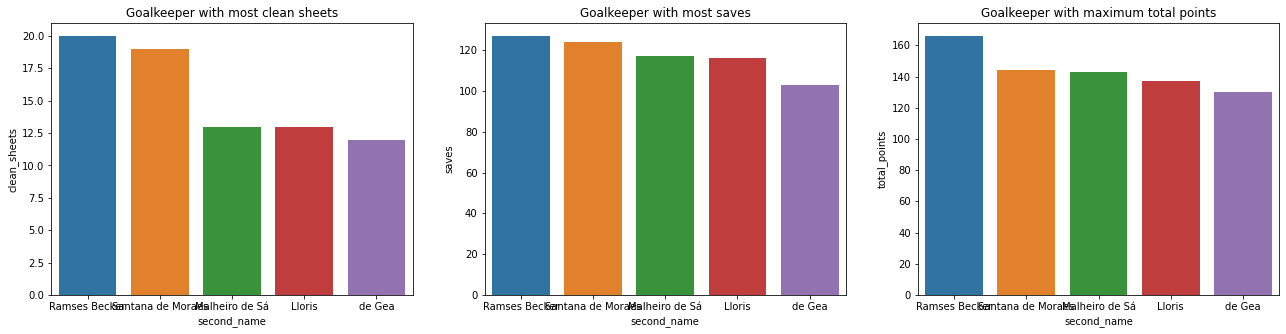

In [21]:
gk = player_data.loc[player_data['position'] == 'GKP']
gk_cleansheets = gk.nlargest(5, 'clean_sheets')
gk_saves = gk.nlargest(5, 'saves')
gk_points = gk.nlargest(5, 'total_points')

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(22,5))
#fig.suptitle('Goalkeeper Stats')

sns.barplot(ax=axes[0], x='second_name', y='clean_sheets', data=gk_cleansheets)
axes[0].set_title('Goalkeeper with most clean sheets')

sns.barplot(ax=axes[1], x='second_name', y='saves', data=gk_saves)
axes[1].set_title('Goalkeeper with most saves')

sns.barplot(ax=axes[2], x='second_name', y='total_points', data=gk_points)
axes[2].set_title('Goalkeeper with maximum total points')

Mid Fielders

Text(0.5, 1.0, 'Midfielders total points wrt cost')

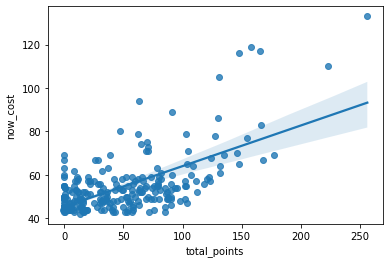

In [22]:
mid = player_data.loc[player_data['position'] == 'MID']
sns.regplot(x='total_points', y='now_cost', data=mid)
axes[0].set_title('Midfielders total points wrt cost')

Forwards

Text(0.5, 1.0, 'Forwards total points wrt cost')

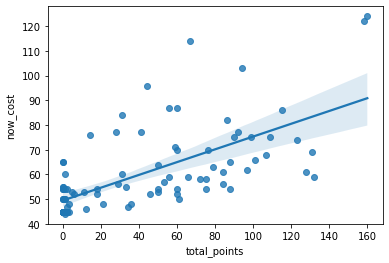

In [23]:
fwd = player_data.loc[player_data['position'] == 'FWD']
sns.regplot(x='total_points', y='now_cost', data=fwd)
axes[0].set_title('Forwards total points wrt cost')

>Top 3 total points scorers of each teams

In [24]:
club_top_three = player_data.groupby("club")['total_points'].nlargest(3).index

In [25]:
club_top_three_df = pd.DataFrame(columns=player_data.columns)
club_df_index = 0
last_club = ""
for club_name, index in club_top_three:
  if last_club != club_name:
    last_club, rank = club_name, 0
  rank+=1
  club_top_three_df.loc[club_df_index] = player_data.iloc[index, :]
  club_top_three_df.loc[club_df_index, 'rank'] = rank
  club_df_index += 1

In [26]:
club_top_three_df_pivot = pd.pivot_table(
    club_top_three_df,
    values="total_points",
    index="club",
    columns="rank"
)

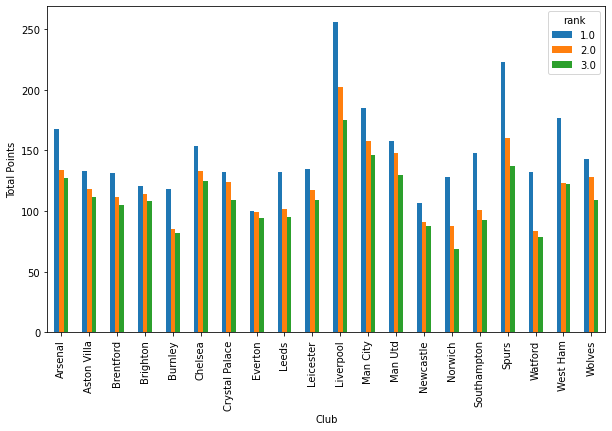

In [27]:
ax = club_top_three_df_pivot.plot(kind="bar")
fig = ax.get_figure()
fig.set_size_inches(10, 6)
ax.set_xlabel("Club")
ax.set_ylabel("Total Points")
fig.savefig("club_top_three_barplot.png")

 >Players’ costs versus total points

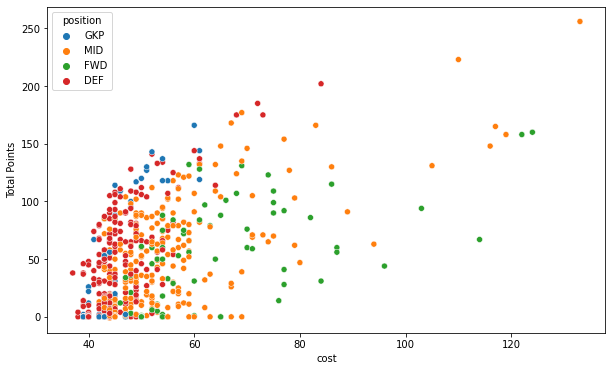

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x='now_cost', y='total_points', hue='position', data=player_data) 
plt.xlabel('cost')
plt.ylabel('Total Points')
plt.show()

In [29]:
player_metric = ['saves','penalties_saved', 'clean_sheets', 'goals_conceded', 'bonus', 'bps',
               'creativity', 'influence', 'threat', 'goals_scored','assists', 'minutes', 'own_goals',
               'yellow_cards', 'red_cards','penalties_missed','points_per_game', 'total_points', 'now_cost']
player_metric_data = player_data[player_metric]

In [30]:
player_metric_data.corr()

,saves,penalties_saved,clean_sheets,goals_conceded,bonus,bps,goals_scored,assists,minutes,own_goals,yellow_cards,red_cards,penalties_missed,total_points,now_cost
saves,1.000000,0.503273,0.218108,0.278388,0.183345,0.337675,-0.088187,-0.092979,0.297115,0.102883,-0.026956,-0.001819,-0.025180,0.257443,-0.014824
penalties_saved,0.503273,1.000000,0.051491,0.153571,0.074082,0.147231,-0.047703,-0.051651,0.136861,-0.019617,-0.039943,-0.021041,-0.013621,0.110118,-0.020742
clean_sheets,0.218108,0.051491,1.000000,0.574790,0.733734,0.895613,0.531569,0.574246,0.846842,0.118878,0.550004,0.164746,0.145908,0.909100,0.481152
goals_conceded,0.278388,0.153571,0.574790,1.000000,0.572989,0.800175,0.396770,0.420954,0.906360,0.230724,0.692609,0.225309,0.097326,0.730044,0.248212
bonus,0.183345,0.074082,0.733734,0.572989,1.000000,0.808400,0.739715,0.691520,0.726047,0.121707,0.486961,0.144255,0.177088,0.878683,0.609419
bps,0.337675,0.147231,0.895613,0.800175,0.808400,1.000000,0.522990,0.584774,0.955922,0.193283,0.630136,0.195415,0.118234,0.948979,0.425321
goals_scored,-0.088187,-0.047703,0.531569,0.396770,0.739715,0.522990,1.000000,0.651134,0.502462,0.015148,0.362934,0.105093,0.317582,0.709423,0.756944
assists,-0.092979,-0.051651,0.574246,0.420954,0.691520,0.584774,0.651134,1.000000,0.545311,0.025276,0.417238,0.140609,0.181701,0.715125,0.602138
minutes,0.297115,0.136861,0.846842,0.906360,0.726047,0.955922,0.502462,0.545311,1.000000,0.205574,0.711588,0.224272,0.137131,0.912752,0.383506
own_goals,0.102883,-0.019617,0.118878,0.230724,0.121707,0.193283,0.015148,0.025276,0.205574,1.000000,0.187360,0.155508,-0.027136,0.134585,0.004620


/Users/akshatajadhav/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akshatajadhav/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akshatajadhav/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

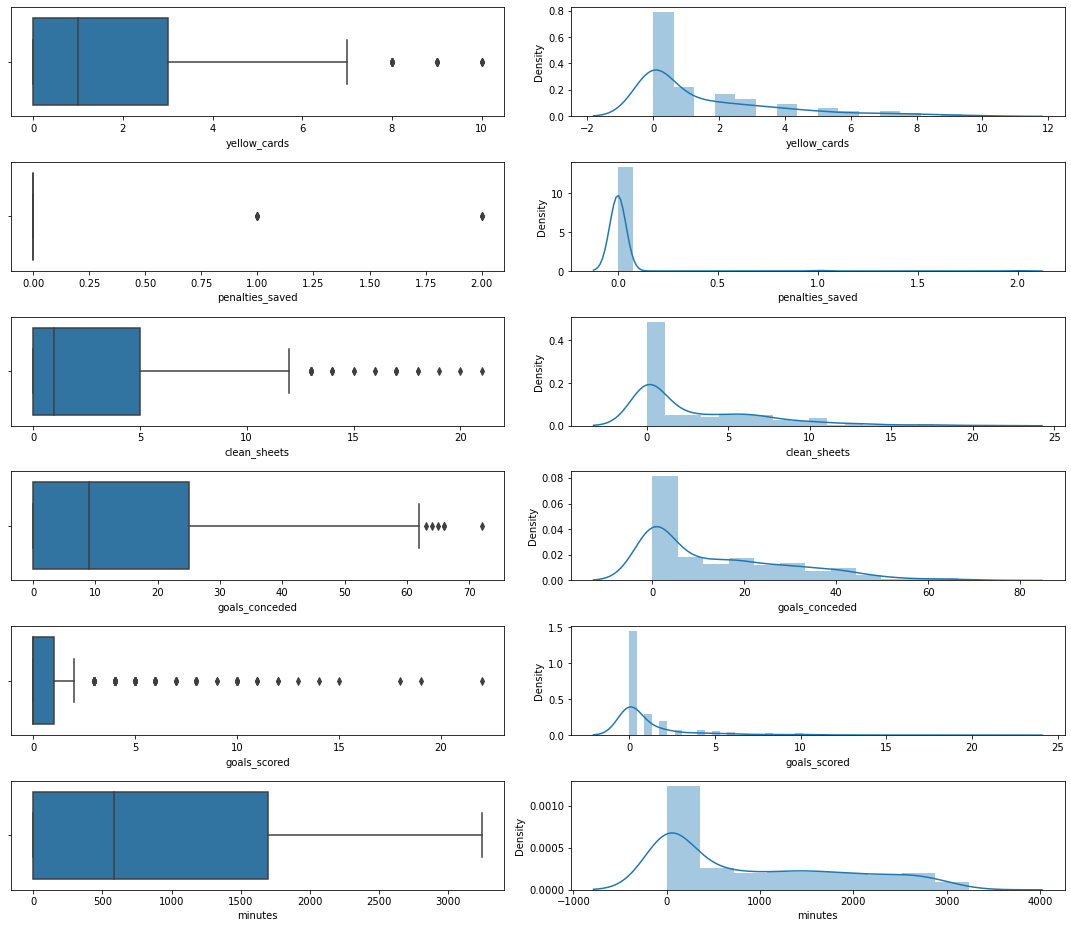

In [31]:
fig, ax = plt.subplots(6, 2, figsize = (15, 13))

sns.boxplot(x= player_data["yellow_cards"], ax = ax[0,0])
sns.distplot(player_data['yellow_cards'], ax = ax[0,1])
sns.boxplot(x= player_data["penalties_saved"], ax = ax[1,0])
sns.distplot(player_data['penalties_saved'], ax = ax[1,1])
sns.boxplot(x= player_data["clean_sheets"], ax = ax[2,0])
sns.distplot(player_data['clean_sheets'], ax = ax[2,1])
sns.boxplot(x= player_data["goals_conceded"], ax = ax[3,0])
sns.distplot(player_data['goals_conceded'], ax = ax[3,1])
sns.boxplot(x= player_data["goals_scored"], ax = ax[4,0])
sns.distplot(player_data['goals_scored'], ax = ax[4,1])
sns.boxplot(x= player_data["minutes"], ax = ax[5,0])
sns.distplot(player_data['minutes'], ax = ax[5,1])

plt.tight_layout()

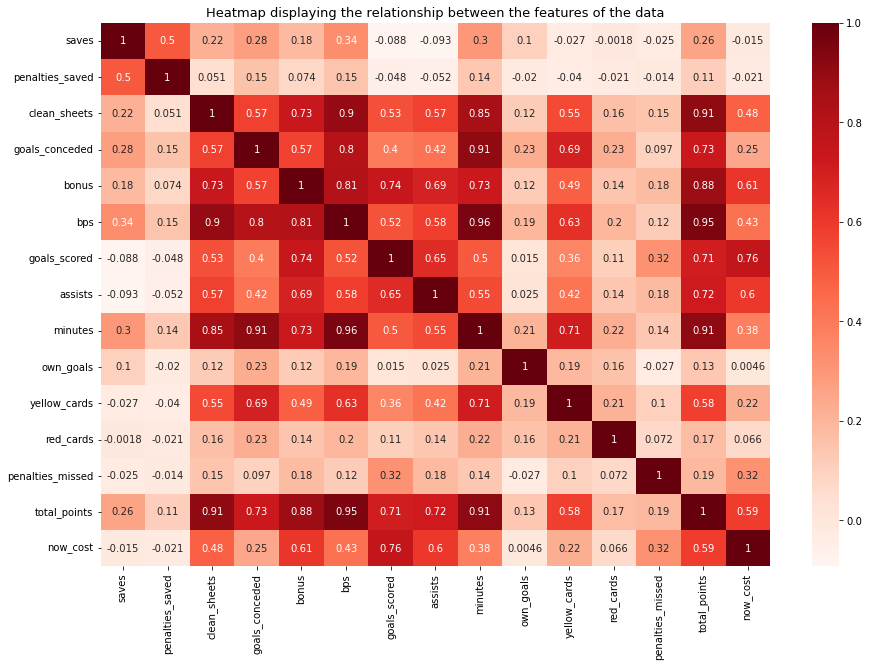

In [32]:
plt.figure(figsize=(15,10))
sns.heatmap(player_metric_data.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data',
         fontsize=13)
plt.show()

## Problem Statement

1. Select the best possible combination of 15 player squad that is, formation of the best possible team to pick from the dataset 

2. Make a prediction of how many points each player will score in the next game week 

## 1. Formation of the best possible team to pick from the dataset 

> With keeping in mind the budget and various player based constraints. Our aim is to maximize the points earned by this configuration

***- The model is linear programming problem (LPP) where we have used the Linear Optimisation technique***


### Kernel Density Estimation
>to show the distribution of points based on the position of the players


In [33]:
def graph_for_each_positions():
  f = plt.figure(figsize=(16,9))
  ax1 = f.add_subplot(2,2,1)
  ax2 = f.add_subplot(2,2,2,sharex=ax1, sharey=ax1)
  ax3 = f.add_subplot(2,2,3,sharex=ax1, sharey=ax1)
  ax4 = f.add_subplot(2,2,4,sharex=ax1, sharey=ax1)
  ax1.set_title('FWD')
  sns.distplot(player_data[player_data.position=='FWD'].total_points, label='FWD',ax=ax1)
  ax1.axvline(np.mean(player_data[player_data.position=='FWD'].total_points),color='red', label='mean')
  ax2.set_title('MID')
  sns.distplot(player_data[player_data.position=='MID'].total_points, label='MID',ax=ax2)
  ax2.axvline(np.mean(player_data[player_data.position=='MID'].total_points),color='red', label='mean')
  ax3.set_title('DEF')
  sns.distplot(player_data[player_data.position=='DEF'].total_points, label='DEF',ax=ax3)
  ax3.axvline(np.mean(player_data[player_data.position=='DEF'].total_points),color='red', label='mean')
  ax4.set_title('GKP')
  sns.distplot(player_data[player_data.position=='GKP'].total_points, label='GKP',ax=ax4)
  ax4.axvline(np.mean(player_data[player_data.position=='GKP'].total_points),color='red', label='mean')
  plt.subplots_adjust(wspace=0.4, hspace=0.4)
  plt.show()

/Users/akshatajadhav/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akshatajadhav/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akshatajadhav/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

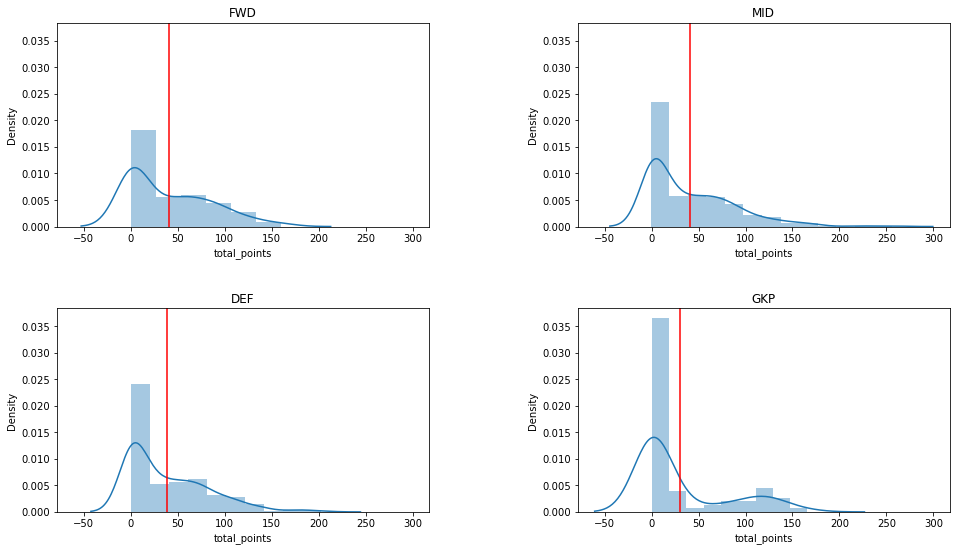

In [34]:
graph_for_each_positions()

### Imputations

The positive skew data is due to the fact that there were players transferred into the Premier League with no previous data and no points the previous season. One of the data's drawbacks is this. If there was no data about these players' previous performance, it would be difficult to judge their performance and properly pick the best options for the season.

**Problem**

1. People with no historic data will be handles by using median and standard deviation that we will randomaly assign the numbers for now.
2. Past performance  of any league and depicte other metric or by using the pay data

In [35]:
no_data_filtered_values = np.where((player_data['total_points'] == 0) & (player_data['minutes'] == 0))

In [36]:
player_data.loc[no_data_filtered_values]

,full_name,first_name,second_name,position_id,position,id,club,team_code,web_name,saves,...,assists,minutes,own_goals,yellow_cards,red_cards,penalties_missed,selected_by_percent,now_cost,points_per_game,total_points
1,Rúnar Alex Rúnarsson,Rúnar Alex,Rúnarsson,1,GKP,2,Arsenal,3,Rúnarsson,0,...,0,0,0,0,0,0,0.5,40,0.0,0
2,Willian Borges Da Silva,Willian,Borges Da Silva,3,MID,3,Arsenal,3,Willian,0,...,0,0,0,0,0,0,0.1,63,0.0,0
8,Héctor Bellerín,Héctor,Bellerín,2,DEF,9,Arsenal,3,Bellerín,0,...,0,0,0,0,0,0,0.2,48,0.0,0
16,Lucas Torreira,Lucas,Torreira,3,MID,18,Arsenal,3,Torreira,0,...,0,0,0,0,0,0,0.1,45,0.0,0
21,Konstantinos Mavropanos,Konstantinos,Mavropanos,2,DEF,24,Arsenal,3,Mavropanos,0,...,0,0,0,0,0,0,0.0,45,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,James Storer,James,Storer,1,GKP,621,Wolves,39,Storer,0,...,0,0,0,0,0,0,0.2,40,0.0,0
724,Hugo Bueno,Hugo,Bueno,2,DEF,635,Wolves,39,Bueno,0,...,0,0,0,0,0,0,0.1,40,0.0,0
725,Bruno André Cavaco Jordão,Bruno André,Cavaco Jordão,3,MID,661,Wolves,39,Jordão,0,...,0,0,0,0,0,0,0.0,45,0.0,0
727,Dion Sanderson,Dion,Sanderson,2,DEF,686,Wolves,39,Sanderson,0,...,0,0,0,0,0,0,0.0,40,0.0,0


In [37]:
def median_on_columns( player_data, condition, impute_cols):
    return player_data.loc[condition][impute_cols].astype(np.float32).median().fillna(0)

def std_on_columns( player_data, condition, impute_cols):
    return player_data.loc[condition][impute_cols].astype(np.float32).std().fillna(0)


In [38]:
impute_cols = ['saves','penalties_saved', 'clean_sheets', 'goals_conceded', 'bonus', 'bps',
               'creativity', 'influence', 'threat', 'goals_scored','assists', 'minutes', 'own_goals',
               'yellow_cards', 'red_cards','penalties_missed','points_per_game', 'total_points']
impute_data = {}
 
for idx, row in player_data.loc[no_data_filtered_values].iterrows():    
    position = row.position
    cost = row.now_cost
    key = (position, cost)

    if key not in impute_data:
        filter = np.where((player_data.total_points!=0)
                &(player_data.minutes!=0)
                &(player_data.position==position)
                &(player_data.now_cost==cost))
        if player_data.loc[filter].shape[0] > 0:
            median = median_on_columns(player_data, filter,impute_cols)
            std = std_on_columns(player_data, filter,impute_cols)
        else:
            std = median = {col:0.0 for col in impute_cols}

        impute_data[key] = (median + np.abs((np.random.randn()/1.5)* std)).to_dict()

for idx, row in player_data.loc[no_data_filtered_values].iterrows():      
    position = row.position
    cost = row.now_cost
    for col in impute_cols:
        player_data.loc[idx, col] = impute_data[(position, cost)][col]

In [39]:
player_data.loc[no_data_filtered_values]

,full_name,first_name,second_name,position_id,position,id,club,team_code,web_name,saves,...,assists,minutes,own_goals,yellow_cards,red_cards,penalties_missed,selected_by_percent,now_cost,points_per_game,total_points
1,Rúnar Alex Rúnarsson,Rúnar Alex,Rúnarsson,1,GKP,2,Arsenal,3,Rúnarsson,33.896286,...,0.000000,793.783691,0.000000,0.000000,0.000000,0.0,0.5,40,4.51017,24.910217
2,Willian Borges Da Silva,Willian,Borges Da Silva,3,MID,3,Arsenal,3,Willian,0.000000,...,7.449668,954.684753,0.000000,2.741611,0.000000,0.0,0.1,63,4.69564,67.406067
8,Héctor Bellerín,Héctor,Bellerín,2,DEF,9,Arsenal,3,Bellerín,0.000000,...,0.597459,2279.121826,0.000000,3.679184,0.030601,0.0,0.2,48,3.108143,83.480255
16,Lucas Torreira,Lucas,Torreira,3,MID,18,Arsenal,3,Torreira,0.000000,...,0.346422,349.122375,0.000000,0.757086,0.000000,0.0,0.1,45,1.230609,12.022943
21,Konstantinos Mavropanos,Konstantinos,Mavropanos,2,DEF,24,Arsenal,3,Mavropanos,0.000000,...,1.381815,3503.437012,0.406083,6.966918,0.406083,0.0,0.0,45,4.29599,128.166229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,James Storer,James,Storer,1,GKP,621,Wolves,39,Storer,33.896286,...,0.000000,793.783691,0.000000,0.000000,0.000000,0.0,0.2,40,4.51017,24.910217
724,Hugo Bueno,Hugo,Bueno,2,DEF,635,Wolves,39,Bueno,0.000000,...,0.200852,540.097656,0.000000,1.401173,0.000000,0.0,0.1,40,1.428118,15.193174
725,Bruno André Cavaco Jordão,Bruno André,Cavaco Jordão,3,MID,661,Wolves,39,Jordão,0.000000,...,0.346422,349.122375,0.000000,0.757086,0.000000,0.0,0.0,45,1.230609,12.022943
727,Dion Sanderson,Dion,Sanderson,2,DEF,686,Wolves,39,Sanderson,0.000000,...,0.200852,540.097656,0.000000,1.401173,0.000000,0.0,0.0,40,1.428118,15.193174


>After filling data we find improvement in data

/Users/akshatajadhav/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akshatajadhav/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akshatajadhav/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

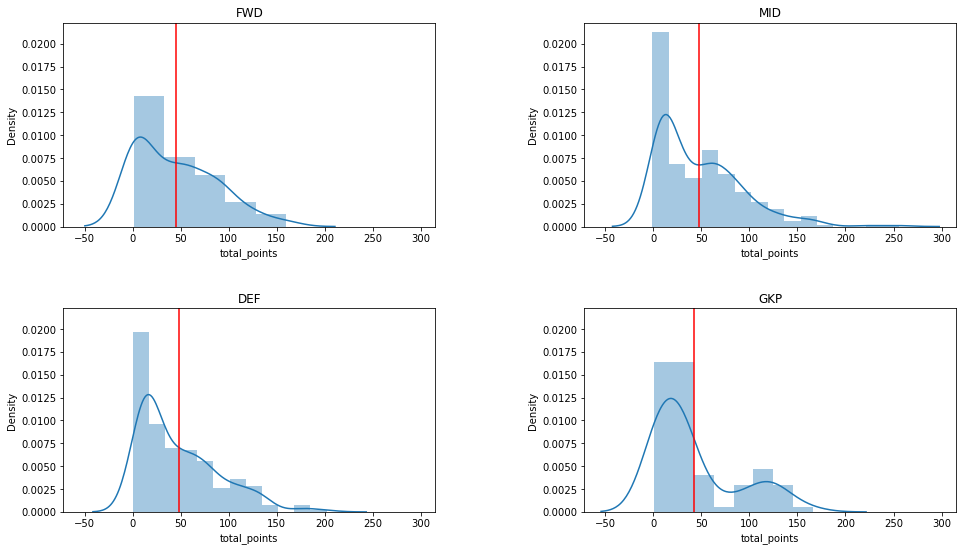

In [40]:
graph_for_each_positions()

### Linear Modelling
>we will begin by simulating the problem in order to select the best 11 players we can with the money we have available.

*Model Initialization*

In [41]:
lp_problem = LpProblem('FantasyTeam', LpMaximize)

In [42]:
lp_problem

FantasyTeam:
MAXIMIZE
None
VARIABLES

In [43]:
def lp_variable_generate(variable, low_bound = 0, up_bound = 1, cat= 'Integer'):
    return pulp.LpVariable(variable, lowBound = low_bound, upBound = up_bound, cat = cat)

*Defining decision variables*

In [44]:
decision_variables = {id : lp_variable_generate('F'+str(id)) for id in player_data.id}

*Defining the constraints with our rules*

In [45]:
def decision_generator(column = False, constraints = False):

    data = player_data

    if isinstance(constraints, dict) and 'column' in constraints and 'what_for' in constraints:
        data = data[data[constraints['column']] == constraints['what_for']]

    total = lpSum([decision_variables[row.id] * (row[column] if isinstance(column, str) else 1) for index, row in data.iterrows()])

    if isinstance(constraints, dict) and 'max_value' in constraints and 'condition' in constraints:
        symbol = constraints['condition']
        max_value = constraints['max_value']
        if symbol == '<':
            total = (total < max_value)
        elif symbol == '>':
            total = (total > max_value)
        elif symbol == '<=':
            total = (total <= max_value)
        elif symbol == '>=':
            total = (total >= max_value)
        elif symbol == '==':
            total = (total == max_value)
        else:
            raise Exception('Illegal condition please provide <,>,<=,>=,==')

    return total

In [46]:
point_decision_constraints={}
cash_decision_constraints = {'max_value' : 1000, 'condition' : '<=' }
gkp_decision_constraints = {'column':'position', 'what_for':'GKP', 'max_value' : 2, 'condition' : '=='}
mid_decision_constraints = {'column':'position', 'what_for':'MID', 'max_value' : 5, 'condition' : '=='}
def_decision_constraints = {'column':'position', 'what_for':'DEF', 'max_value' : 5, 'condition' : '=='}
fwd_decision_constraints = {'column':'position', 'what_for':'FWD', 'max_value' : 3, 'condition' : '=='}

In [47]:
lp_problem += decision_generator('total_points')

In [48]:
lp_problem += decision_generator('now_cost', cash_decision_constraints)

In [49]:
lp_problem += decision_generator(constraints = gkp_decision_constraints)

In [50]:
lp_problem += decision_generator(constraints = mid_decision_constraints)

In [51]:
lp_problem += decision_generator(constraints = fwd_decision_constraints)

In [52]:
lp_problem += decision_generator(constraints = def_decision_constraints)

In [53]:
for team_code in player_data.team_code.unique():
    team_constraints = {}
    team_constraints['column'] = 'team_code'
    team_constraints['what_for'] = team_code
    team_constraints['max_value'] = 3
    team_constraints['condition'] = '<='

    lp_problem += decision_generator(constraints = team_constraints)

In [54]:
# lp_problem

In [55]:
lp_problem.writeLP('FantasyTeam.lp')
optimization_result = lp_problem.solve()
assert optimization_result == LpStatusOptimal
print("Status:", LpStatus[lp_problem.status])
print("Optimal Solution to the problem: ", value(lp_problem.objective))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/akshatajadhav/opt/anaconda3/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6_/rw1kgql93nb2dswz2brhzmxr0000gn/T/6845ffce69ae4d0e8abf692e9f7bf4a1-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/6_/rw1kgql93nb2dswz2brhzmxr0000gn/T/6845ffce69ae4d0e8abf692e9f7bf4a1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 30 COLUMNS
At line 4406 RHS
At line 4432 BOUNDS
At line 5163 ENDATA
Problem MODEL has 25 rows, 730 columns and 2190 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2403.42 - 0.00 seconds
Cgl0004I processed model has 25 rows, 653 columns (653 integer (607 of which binary)) and 1959 elements
Cbc0038I Initial state - 4 integers unsatisfied sum - 0.444444
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. -2396.62 iterations 3

In [56]:
decision = {v.name: v.varValue for v in  lp_problem.variables()}
#decision

In [57]:
player_data['decision'] = player_data.id.apply(lambda id: decision[decision_variables[id].name])

In [58]:
player_data[player_data.decision==1].sort_values('position_id')

,full_name,first_name,second_name,position_id,position,id,club,team_code,web_name,saves,...,minutes,own_goals,yellow_cards,red_cards,penalties_missed,selected_by_percent,now_cost,points_per_game,total_points,decision
378,Alisson Ramses Becker,Alisson,Ramses Becker,1,GKP,231,Liverpool,14,Alisson,65.0,...,2880.000000,1.000000,0.000000,0.000000,0.0,9.0,60,5.2,166.000000,1.0
716,José Malheiro de Sá,José,Malheiro de Sá,1,GKP,475,Wolves,39,Sá,116.0,...,3060.000000,1.000000,3.000000,0.000000,0.0,9.6,52,4.2,143.000000,1.0
212,Ethan Ampadu,Ethan,Ampadu,2,DEF,139,Chelsea,8,Ampadu,0.0,...,3503.437012,0.406083,6.966918,0.406083,0.0,0.0,45,4.29599,128.166229,1.0
225,Robert Kenedy Nunes do Nascimento,Robert Kenedy,Nunes do Nascimento,2,DEF,690,Chelsea,8,Kenedy,0.0,...,3503.437012,0.406083,6.966918,0.406083,0.0,0.0,45,4.29599,128.166229,1.0
376,Virgil van Dijk,Virgil,van Dijk,2,DEF,229,Liverpool,14,van Dijk,0.0,...,2880.000000,0.000000,3.000000,0.000000,0.0,20.2,68,5.5,175.000000,1.0
384,Trent Alexander-Arnold,Trent,Alexander-Arnold,2,DEF,237,Liverpool,14,Alexander-Arnold,0.0,...,2583.000000,0.000000,2.000000,0.000000,0.0,38.8,84,7.0,202.000000,1.0
413,João Pedro Cavaco Cancelo,João Pedro Cavaco,Cancelo,2,DEF,256,Man City,43,Cancelo,0.0,...,2867.000000,0.000000,7.000000,0.000000,0.0,40.7,72,5.8,185.000000,1.0
19,Bukayo Saka,Bukayo,Saka,3,MID,22,Arsenal,3,Saka,0.0,...,2654.000000,0.000000,6.000000,0.000000,0.0,29.4,67,4.9,168.000000,1.0
261,James Rodríguez,James,Rodríguez,3,MID,166,Everton,11,James,0.0,...,2516.743896,0.000000,3.803011,0.000000,0.0,0.5,69,5.010337,162.287842,1.0
550,James Ward-Prowse,James,Ward-Prowse,3,MID,341,Southampton,20,Ward-Prowse,0.0,...,2945.000000,0.000000,3.000000,1.000000,0.0,6.7,65,4.5,148.000000,1.0


In [59]:
player_data[player_data.decision==1].total_points.sum()

2396.6203002929688

In [60]:
player_data[player_data.decision==1].now_cost.sum()

995

### Thoughts

- The dream team that was chosen is shown above
- We can see that the optimisation algorithm made sure that the constraints were followed. There are four defenders, four midfielders, and two forwards on the team
- It has also depleted the overall amount of money available to buy players, utilised 999
- And the highest possible total score is 2372

## 2. Predicting the points, a player will score in the upcoming gameweek

> points each player will score in the next game week

***- The Machine Learning algorithms used are Linear Regression model and Random Forest Regression***




### Data mining

*We are considering for 3 players - Hugo LLoris, Mohamed Salah, Heung Min Son*

In [61]:
hugo_lloris_17_18 = "https://github.com/vaastav/Fantasy-Premier-League/raw/master/data/2017-18/players/Hugo_Lloris/gw.csv"
hugo_lloris_18_19 = "https://github.com/vaastav/Fantasy-Premier-League/raw/master/data/2018-19/players/Hugo_Lloris_351/gw.csv"
hugo_lloris_19_20 = "https://github.com/vaastav/Fantasy-Premier-League/raw/master/data/2019-20/players/Hugo_Lloris_340/gw.csv"
hugo_lloris_20_21 = "https://github.com/vaastav/Fantasy-Premier-League/raw/master/data/2020-21/players/Hugo_Lloris_383/gw.csv"
hugo_lloris_21_22 = "https://github.com/vaastav/Fantasy-Premier-League/raw/master/data/2021-22/players/Hugo_Lloris_353/gw.csv"


In [62]:
mohamed_salah_17_18 = "https://github.com/vaastav/Fantasy-Premier-League/raw/master/data/2017-18/players/Mohamed_Salah/gw.csv"
mohamed_salah_18_19 = "https://github.com/vaastav/Fantasy-Premier-League/raw/master/data/2018-19/players/Mohamed_Salah_253/gw.csv"
mohamed_salah_19_20 = "https://github.com/vaastav/Fantasy-Premier-League/raw/master/data/2019-20/players/Mohamed_Salah_191/gw.csv"
mohamed_salah_20_21 = "https://github.com/vaastav/Fantasy-Premier-League/raw/master/data/2020-21/players/Mohamed_Salah_254/gw.csv"
mohamed_salah_21_22 = "https://github.com/vaastav/Fantasy-Premier-League/raw/master/data/2021-22/players/Mohamed_Salah_233/gw.csv"


In [63]:
heung_min_son_17_18 = "https://github.com/vaastav/Fantasy-Premier-League/raw/master/data/2017-18/players/Heung-Min_Son/gw.csv"
heung_min_son_18_19 = "https://github.com/vaastav/Fantasy-Premier-League/raw/master/data/2018-19/players/Heung-Min_Son_367/gw.csv"
heung_min_son_19_20 = "https://github.com/vaastav/Fantasy-Premier-League/raw/master/data/2019-20/players/Heung-Min_Son_342/gw.csv"
heung_min_son_20_21 = "https://github.com/vaastav/Fantasy-Premier-League/raw/master/data/2020-21/players/Heung-Min_Son_390/gw.csv"
heung_min_son_21_22 = "https://github.com/vaastav/Fantasy-Premier-League/raw/master/data/2021-22/players/Heung-Min_Son_359/gw.csv"

In [64]:
hugo_lloris = pd.concat(map(pd.read_csv, [hugo_lloris_17_18,
                     hugo_lloris_18_19,
                     hugo_lloris_19_20,
                     hugo_lloris_20_21,
                     hugo_lloris_21_22]) , ignore_index=True)

In [65]:
mohamed_salah = pd.concat(map(pd.read_csv, [mohamed_salah_17_18,
                     mohamed_salah_18_19,
                     mohamed_salah_19_20,
                     mohamed_salah_20_21,
                     mohamed_salah_21_22]) , ignore_index=True)

In [66]:
heung_min_son = pd.concat(map(pd.read_csv, [heung_min_son_17_18,
                     heung_min_son_18_19,
                     heung_min_son_19_20,
                     heung_min_son_20_21,
                     heung_min_son_21_22]) , ignore_index=True)

In [67]:
hugo_lloris = hugo_lloris.fillna(0)

In [68]:
mohamed_salah = mohamed_salah.fillna(0)

In [69]:
heung_min_son = heung_min_son.fillna(0)

In [70]:
player = hugo_lloris

### Data Modeling

In [71]:
from sklearn.model_selection import train_test_split
def player_model(player): 
    X = player.drop(['clean_sheets','fixture','goals_conceded','saves','penalties_saved','kickoff_time','total_points', 'kickoff_time' , 'kickoff_time_formatted'],axis=1)
    y = player['total_points']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    return X, y, X_train, X_test, y_train, y_test

**Hugo Lloris**

In [72]:
# hugo_lloris_X, hugo_lloris_y, hugo_lloris_X_train, hugo_lloris_X_test, hugo_lloris_y_train, hugo_lloris_y_test = player_model(hugo_lloris)

In [73]:
X, y, X_train, X_test, y_train, y_test = player_model(hugo_lloris)

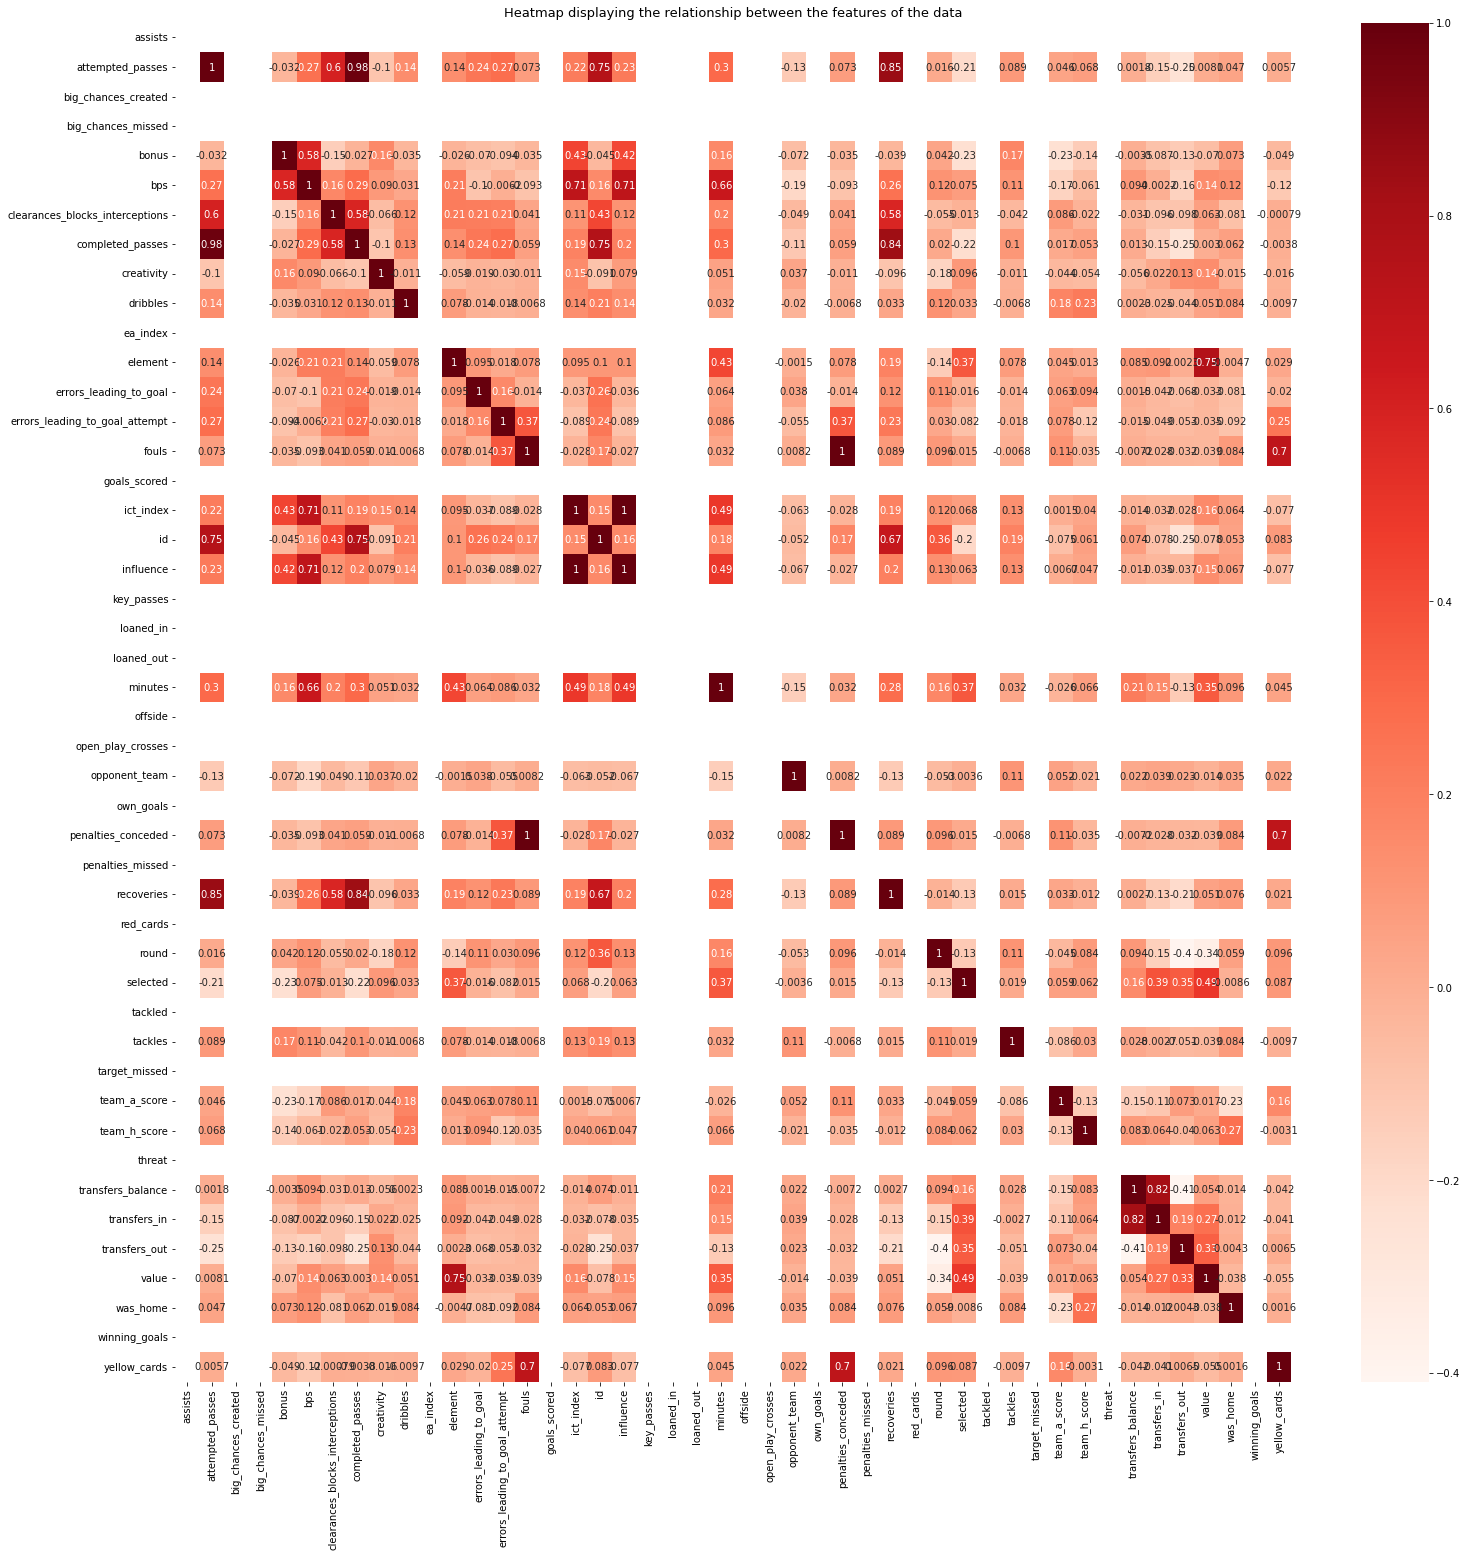

In [74]:
plt.figure(figsize=(25,25))
sns.heatmap(X_train.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data',
         fontsize=13)
plt.show()

**Mohamed Salah**

In [75]:
# mohamed_salah_X, mohamed_salah_y, mohamed_salah_X_train, mohamed_salah_X_test, mohamed_salah_y_train, mohamed_salah_y_test = player_model(mohamed_salah)

In [76]:
X, y, X_train, X_test, y_train, y_test = player_model(mohamed_salah)

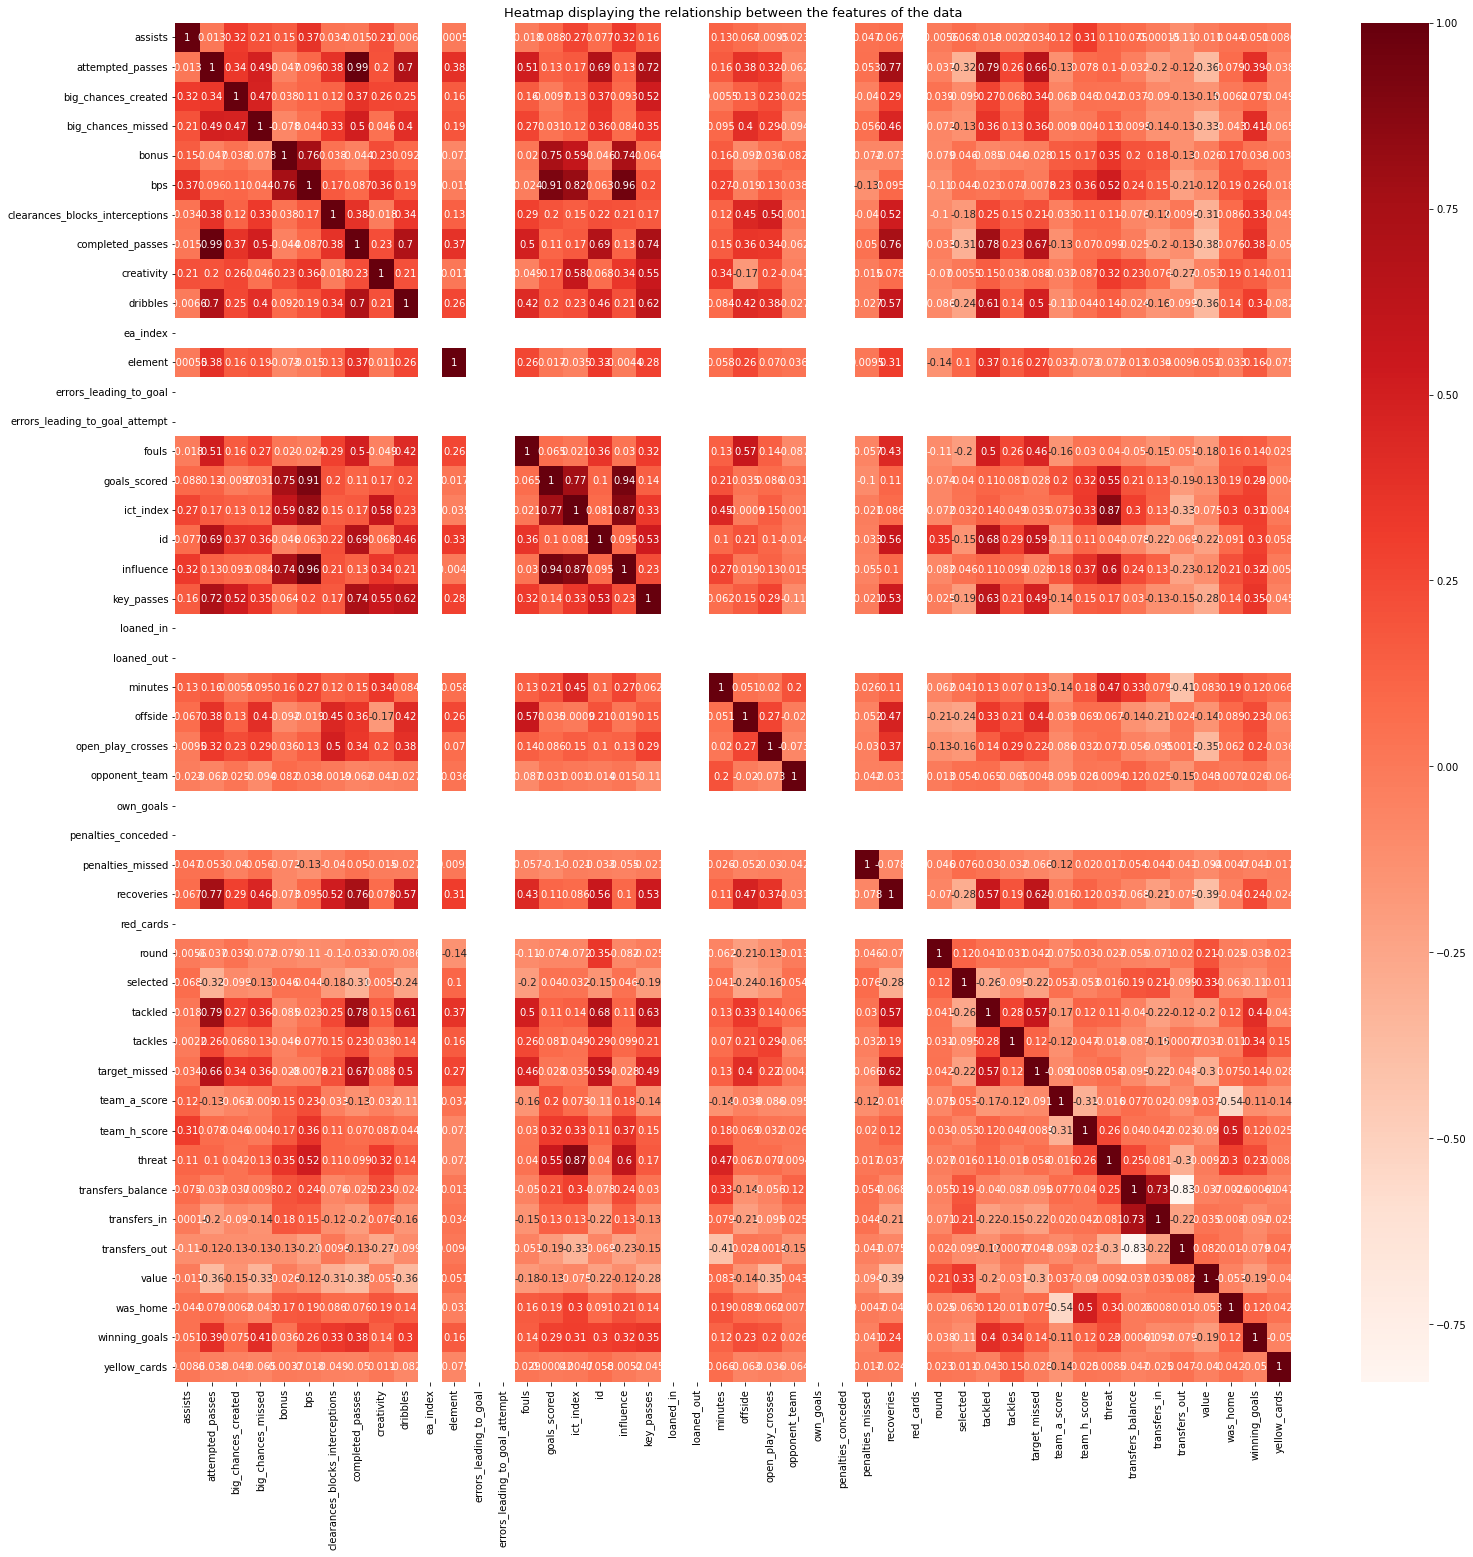

In [77]:
plt.figure(figsize=(25,25))
sns.heatmap(X_train.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data',
         fontsize=13)
plt.show()

**Heung Min Son**

In [78]:
# heung_min_son_X, heung_min_son_y, heung_min_son_X_train, heung_min_son_X_test, heung_min_son_y_train, heung_min_son_y_test = player_model(heung_min_son)

In [79]:
X, y, X_train, X_test, y_train, y_test = player_model(heung_min_son)

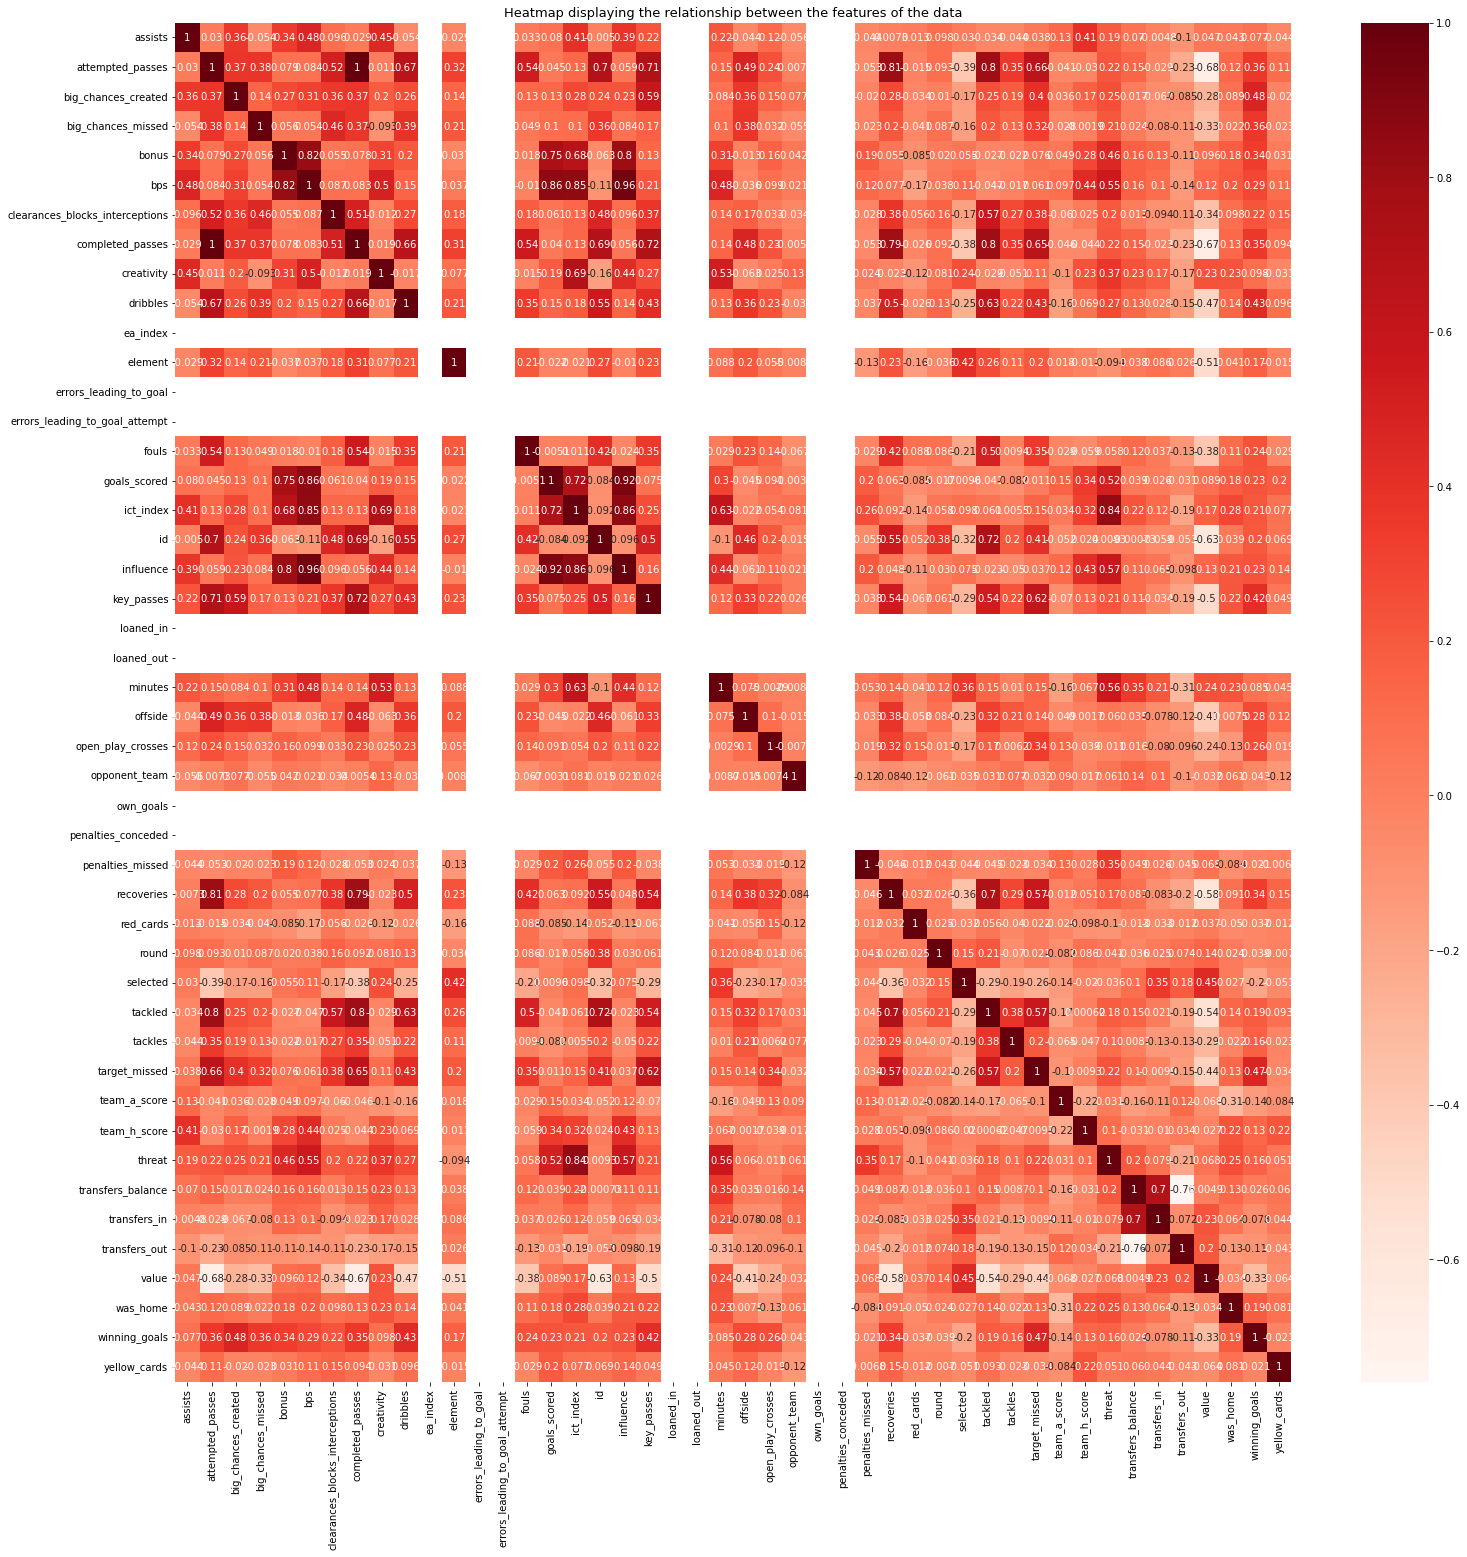

In [80]:
plt.figure(figsize=(25,25))
sns.heatmap(X_train.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data',
         fontsize=13)
plt.show()

### Linear Regression

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [82]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
y_predicted = regression_model.predict(X_test)

In [83]:
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)

In [91]:
print('R2 score: ', r2)
print('Root mean squared error: ', rmse)

R2 score:  0.9813041360306307
Root mean squared error:  0.34327108131571105


In [85]:
y_pred = regression_model.predict(X_test)
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

,Actual,Predicted
63,6,6.893814
48,4,4.111698
46,0,0.484532
35,1,1.458753
113,2,1.929280
141,1,0.667667
176,9,8.381952
37,1,-0.102645
26,3,2.645441
50,8,7.582294


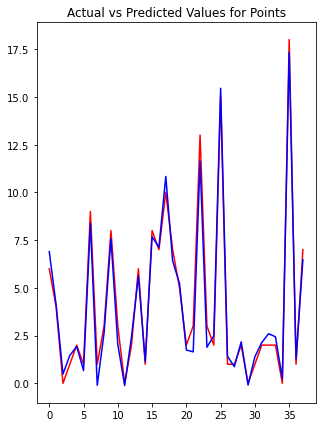

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 7))

plt.plot(y_test.values, color="r", label="Actual Value")
plt.plot(y_predicted, color="b", label="Predicted Values")
 
plt.title('Actual vs Predicted Values for Points')
plt.show()
plt.close()

### Random Forest


In [87]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=100)
model = random_forest.fit(X_train, y_train)

In [88]:
from sklearn.metrics import r2_score
test_y_ = random_forest.predict(X_test)
print('Mean absolute error: %.2f' % np.mean(np.absolute(test_y_ - y_test)))
print('Residual sum of squares (MSE): %.2f' % np.mean((test_y_ - y_test) **2 ))
print('R2-score: %.2f' % r2_score(test_y_, y_test))

Mean absolute error: 0.72
Residual sum of squares (MSE): 1.24
R2-score: 0.94


In [89]:
y_pred = model.predict(X_test)
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

,Actual,Predicted
63,6,4.27
48,4,4.43
46,0,0.02
35,1,1.02
113,2,2.21
141,1,0.46
176,9,12.31
37,1,0.98
26,3,2.36
50,8,5.43


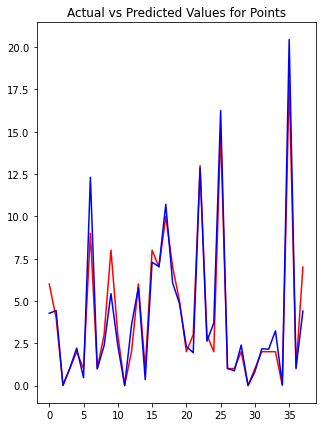

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 7))


plt.plot(y_test.values, color="r", label="Actual Value")
plt.plot(y_pred, color="b", label="Predicted Values")
 

plt.title('Actual vs Predicted Values for Points')


plt.show()
plt.close()

### Thoughts

- We have predicted the total_points for the above mentioned players
- The most valuable player, on the other hand, will be the one with the greatest points and the lowest cost, i.e. the one with the highest points per cost (or points per million)

## Conclusion

<br />
<center>
<img src="images/victory.gif" width=1000 />
</center>

- After observing the performance and all the relevant parameters and scores, we think that our Linear Regression model performed better 
- We can use Linear Programming Problem approach by using the Linear Optimization technique in which we have formed a team that will fetch the most number of points and accordingly help in selecting the players 
- After careful observations, we have reached to a conclusion that while predicting the points of a particular player on the basis of various features and taking into account all the scenarios, Linear Regression model will be a best fit to predict the points




### References

Citations:

https://fantasy.premierleague.com/

https://github.com/vaastav/Fantasy-Premier-League

https://keytodatascience.com/fpl-machine-learning/

https://towardsdatascience.com/linear-programming-using-python-priyansh-22b5ee888fe0

